# Data programming with Snorkel: RNA

## Preamble

In [1]:
# Importations.
import pandas as pd
import numpy as np
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.analysis import get_label_buckets
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
import string # For punctuation.
import os
import itertools

# Define random state seed to be used throughout.
seed = 123

## Define functions

## Read data

In [2]:
# Read data files.
df = pd.read_csv("../data/rna_titles/timecourse_rna_titles_2300.csv")

# Explore data.
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              2300 non-null   int64 
 1   Title             2300 non-null   object
 2   Authors           2297 non-null   object
 3   Citation          2300 non-null   object
 4   First Author      2297 non-null   object
 5   Journal/Book      2300 non-null   object
 6   Publication Year  2300 non-null   int64 
 7   Create Date       2300 non-null   object
 8   PMCID             1301 non-null   object
 9   NIHMS ID          223 non-null    object
 10  DOI               2299 non-null   object
 11  Label             2300 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 215.8+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,33485387,time-course single-cell rna sequencing reveals...,"Sun C, Wang H, Ma Q, Chen C, Yue J, Li B, Zhan...",Cell Biosci. 2021 Jan 23;11(1):24. doi: 10.118...,Sun C,Cell Biosci,2021,2021/01/24,PMC7824938,NaN,10.1186/s13578-021-00541-4,1
1,31852401,longitudinal rna-seq analysis of the repeatabi...,"Rondina MT, Voora D, Simon LM, Schwertz H, Har...",Circ Res. 2020 Feb 14;126(4):501-516. doi: 10....,Rondina MT,Circ Res,2020,2019/12/20,PMC7323475,NIHMS1549147,10.1161/CIRCRESAHA.119.315215,1
2,30527648,time series analysis of gene changes and proce...,"Wu D, Zhou M, Li L, Leng X, Zhang Z, Wang N, S...",Burns. 2019 Mar;45(2):387-397. doi: 10.1016/j....,Wu D,Burns,2019,2018/12/12,NaN,NaN,10.1016/j.burns.2018.08.022,1
3,25116415,a time course-dependent metastatic gene expres...,"Chen R, Zhang G, Zhou Y, Li N, Lin J.",Diagn Pathol. 2014 Aug 13;9:155. doi: 10.1186/...,Chen R,Diagn Pathol,2014,2014/08/14,PMC4149277,NaN,10.1186/s13000-014-0155-2,1
4,28370374,the gene expression and immunohistochemical ti...,"Mose KF, Burton M, Thomassen M, Andersen F, Kr...",Exp Dermatol. 2017 Oct;26(10):926-933. doi: 10...,Mose KF,Exp Dermatol,2017,2017/04/04,NaN,NaN,10.1111/exd.13345,1


## Process data

In [3]:
# Train-test split (80% / 20%, stratified by gold label value).
X_train, X_test, y_train, y_test = train_test_split(df["Title"], 
                                                    df["Label"], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df["Label"])
df_train = df.iloc[X_train.index].reset_index(drop = True)
df_test = df.iloc[X_test.index].reset_index(drop = True)

# Set data types.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = y_train.to_numpy(dtype = int)
y_test = y_test.to_numpy(dtype = int)

print(df_train.info())
display(df_train.head())
print(df_test.info())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              1840 non-null   int64 
 1   Title             1840 non-null   object
 2   Authors           1839 non-null   object
 3   Citation          1840 non-null   object
 4   First Author      1839 non-null   object
 5   Journal/Book      1840 non-null   object
 6   Publication Year  1840 non-null   int64 
 7   Create Date       1840 non-null   object
 8   PMCID             1051 non-null   object
 9   NIHMS ID          172 non-null    object
 10  DOI               1840 non-null   object
 11  Label             1840 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 172.6+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,16632472,"structural, biochemical, and dynamic character...","Kang X, Hu Y, Li Y, Guo X, Jiang X, Lai L, Xia...",J Biol Chem. 2006 Jun 30;281(26):18216-26. doi...,Kang X,J Biol Chem,2006,2006/04/25,NaN,NaN,10.1074/jbc.M513241200,0
1,29149186,cell cycle time series gene expression data en...,"Szedlak A, Sims S, Smith N, Paternostro G, Pie...",PLoS Comput Biol. 2017 Nov 17;13(11):e1005849....,Szedlak A,PLoS Comput Biol,2017,2017/11/18,PMC5711035,NaN,10.1371/journal.pcbi.1005849,1
2,15013133,temporal patterns of gene expression after acu...,"Lee CW, Stabile E, Kinnaird T, Shou M, Devaney...",J Am Coll Cardiol. 2004 Feb 4;43(3):474-82. do...,Lee CW,J Am Coll Cardiol,2004,2004/03/12,NaN,NaN,10.1016/j.jacc.2003.09.033,1
3,27071649,"saxs studies of rna: structures, dynamics, and...","Chen Y, Pollack L.",Wiley Interdiscip Rev RNA. 2016 Jul;7(4):512-2...,Chen Y,Wiley Interdiscip Rev RNA,2016,2016/04/14,PMC4909577,NIHMS768254,10.1002/wrna.1349,0
4,21894962,mapping the landscape of rna dynamics with nmr...,"Rinnenthal J, Buck J, Ferner J, Wacker A, Fürt...",Acc Chem Res. 2011 Dec 20;44(12):1292-301. doi...,Rinnenthal J,Acc Chem Res,2011,2011/09/08,NaN,NaN,10.1021/ar200137d,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              460 non-null    int64 
 1   Title             460 non-null    object
 2   Authors           458 non-null    object
 3   Citation          460 non-null    object
 4   First Author      458 non-null    object
 5   Journal/Book      460 non-null    object
 6   Publication Year  460 non-null    int64 
 7   Create Date       460 non-null    object
 8   PMCID             250 non-null    object
 9   NIHMS ID          51 non-null     object
 10  DOI               459 non-null    object
 11  Label             460 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 43.2+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,13677474,temporal progression of gene expression respon...,"Wang H, Miyazaki S, Kawai K, Deyholos M, Galbr...",Plant Mol Biol. 2003 Jul;52(4):873-91. doi: 10...,Wang H,Plant Mol Biol,2003,2003/09/19,NaN,NaN,10.1023/a:1025029026375,1
1,31997507,temporal profile of hev rna concentration in b...,"Goel A, V Padmaprakash K, Benjamin M, Katiyar ...",J Viral Hepat. 2020 Jun;27(6):631-637. doi: 10...,Goel A,J Viral Hepat,2020,2020/01/31,NaN,NaN,10.1111/jvh.13266,0
2,19147844,dynamic gene expression is required for anteri...,"Pechmann M, McGregor AP, Schwager EE, Feitosa ...",Proc Natl Acad Sci U S A. 2009 Feb 3;106(5):14...,Pechmann M,Proc Natl Acad Sci U S A,2009,2009/01/17,PMC2635816,NaN,10.1073/pnas.0811150106,0
3,11606741,development of a two-part transcription probe ...,"Li Z, Piggot PJ.",Proc Natl Acad Sci U S A. 2001 Oct 23;98(22):1...,Li Z,Proc Natl Acad Sci U S A,2001,2001/10/19,PMC60089,NaN,10.1073/pnas.221454798,1
4,21176199,the complexity of gene expression dynamics rev...,"Sun X, Zou Y, Nikiforova V, Kurths J, Walther D.",BMC Bioinformatics. 2010 Dec 22;11:607. doi: 1...,Sun X,BMC Bioinformatics,2010,2010/12/24,PMC3098107,NaN,10.1186/1471-2105-11-607,1


In [4]:
# Split off validation set from training set.
# Train-val split (90% / 10%, stratified by gold label value).
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1, 
                                                  random_state = 42,
                                                  stratify = y_train)
df_train = df.iloc[X_train.index].reset_index(drop = True)
df_val = df.iloc[X_val.index].reset_index(drop = True)

# Set data types.
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

print(df_train.info())
display(df_train.head())
print(df_val.info())
display(df_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              1656 non-null   int64 
 1   Title             1656 non-null   object
 2   Authors           1655 non-null   object
 3   Citation          1656 non-null   object
 4   First Author      1655 non-null   object
 5   Journal/Book      1656 non-null   object
 6   Publication Year  1656 non-null   int64 
 7   Create Date       1656 non-null   object
 8   PMCID             943 non-null    object
 9   NIHMS ID          149 non-null    object
 10  DOI               1656 non-null   object
 11  Label             1656 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 155.4+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,21205307,time-series clustering of gene expression in i...,"Ghandhi SA, Sinha A, Markatou M, Amundson SA.",BMC Genomics. 2011 Jan 4;12:2. doi: 10.1186/14...,Ghandhi SA,BMC Genomics,2011,2011/01/06,PMC3022823,NaN,10.1186/1471-2164-12-2,1
1,25409906,dynamic analyses of alternative polyadenylatio...,"Xia Z, Donehower LA, Cooper TA, Neilson JR, Wh...",Nat Commun. 2014 Nov 20;5:5274. doi: 10.1038/n...,Xia Z,Nat Commun,2014,2014/11/21,PMC4467577,NIHMS674338,10.1038/ncomms6274,0
2,14984408,temporal and spatial patterns of kv1.1 and kv1...,"Karimi-Abdolrezaee S, Eftekharpour E, Fehlings...",Eur J Neurosci. 2004 Feb;19(3):577-89. doi: 10...,Karimi-Abdolrezaee S,Eur J Neurosci,2004,2004/02/27,NaN,NaN,10.1111/j.0953-816x.2004.03164.x,0
3,19340919,simultaneously segmenting multiple gene expres...,"Tadepalli S, Ramakrishnan N, Watson LT, Mishra...",J Bioinform Comput Biol. 2009 Apr;7(2):339-56....,Tadepalli S,J Bioinform Comput Biol,2009,2009/04/03,NaN,NaN,10.1142/s0219720009004114,1
4,18547802,rna dynamics: it is about time,"Al-Hashimi HM, Walter NG.",Curr Opin Struct Biol. 2008 Jun;18(3):321-9. d...,Al-Hashimi HM,Curr Opin Struct Biol,2008,2008/06/13,PMC2580758,NIHMS74438,10.1016/j.sbi.2008.04.004,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              184 non-null    int64 
 1   Title             184 non-null    object
 2   Authors           184 non-null    object
 3   Citation          184 non-null    object
 4   First Author      184 non-null    object
 5   Journal/Book      184 non-null    object
 6   Publication Year  184 non-null    int64 
 7   Create Date       184 non-null    object
 8   PMCID             108 non-null    object
 9   NIHMS ID          23 non-null     object
 10  DOI               184 non-null    object
 11  Label             184 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 17.4+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,27249342,recent advances in dynamic m6a rna modification,"Cao G, Li HB, Yin Z, Flavell RA.",Open Biol. 2016 Apr;6(4):160003. doi: 10.1098/...,Cao G,Open Biol,2016,2016/06/02,PMC4852458,NaN,10.1098/rsob.160003,0
1,16420705,discovery of time-delayed gene regulatory netw...,"Li X, Rao S, Jiang W, Li C, Xiao Y, Guo Z, Zha...",BMC Bioinformatics. 2006 Jan 18;7:26. doi: 10....,Li X,BMC Bioinformatics,2006,2006/01/20,PMC1386718,NaN,10.1186/1471-2105-7-26,0
2,27409645,evaluation of immortalized avpv- and arcuate-s...,"Jacobs DC, Veitch RE, Chappell PE.",Endocrinology. 2016 Sep;157(9):3410-9. doi: 10...,Jacobs DC,Endocrinology,2016,2016/07/14,NaN,NaN,10.1210/en.2016-1294,1
3,29615554,flying the rna nest: drosophila reveals novel ...,"Lefebvre FA, Lécuyer É.",J Dev Biol. 2018 Mar 7;6(1):5. doi: 10.3390/jd...,Lefebvre FA,J Dev Biol,2018,2018/04/05,PMC5875563,NaN,10.3390/jdb6010005,1
4,23157550,exploring the dynamics of four rna-dependent r...,"Shen H, Moustafa IM, Cameron CE, Colina CM.",J Phys Chem B. 2012 Dec 20;116(50):14515-24. d...,Shen H,J Phys Chem B,2012,2012/11/20,PMC5718632,NIHMS922948,10.1021/jp302709v,0


0    0.62087
1    0.37913
Name: Label, dtype: float64


<AxesSubplot:>

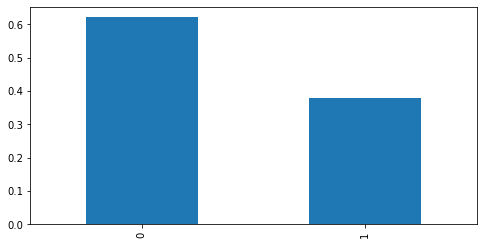

In [5]:
# View gold label distribution.
print(df["Label"].value_counts(normalize = True))
df["Label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

0    0.620773
1    0.379227
Name: Label, dtype: float64


<AxesSubplot:>

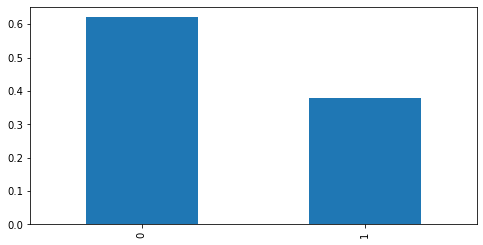

In [6]:
print(df_train["Label"].value_counts(normalize = True))
df_train["Label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

0    0.621739
1    0.378261
Name: Label, dtype: float64


<AxesSubplot:>

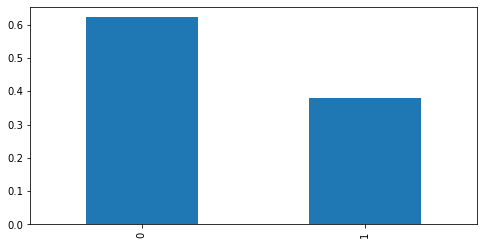

In [7]:
print(df_test["Label"].value_counts(normalize = True))
df_test["Label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

0    0.619565
1    0.380435
Name: Label, dtype: float64


<AxesSubplot:>

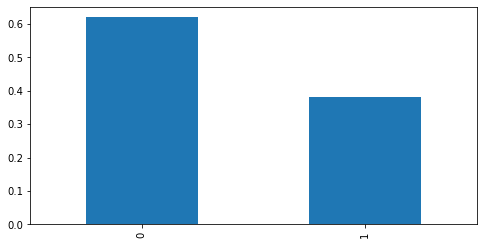

In [8]:
print(df_val["Label"].value_counts(normalize = True))
df_val["Label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

## Labeling functions

In [9]:
# Label macros.
ABSTAIN = -1
EXCLUDE = 0
INCLUDE = 1

In [10]:
# Data for labeling functions.
unwanted_animals = ["xenopus", "marine", "aquatic", "cow", "Bos", "bovine", "cattle", "sheep", 
                   "ovine", "caprine", "goat", "livestock", "pig", "porcine", "amphibian", 
                   "reptile", "frog", "snake", "fish", "cichlid", "crustacean", "crab", "insect", 
                   "chicken", "duck", "mallard", "finch", "bird", "avian", "arachnid", "yak",
                   "chordate", "Ciona", "trout", "salmon", "heifer"]
unwanted_terms = ["NMR", "MD", "molecular dynamic", "RNA world", "wastewater", 
                 "water", "viral load", "RNA degradation", "RNA structur", "secondary structur", 
                 "folding", "regulat", "promoter", "spectroscop", "spectr", "RNA decay", "RNA replication", 
                 "transcription factor", "switch", "control", "RNA metaboli", 
                 "population dynamics", "evolution", "protein", "conformation", "viral dynamics", 
                 "polymerase", "telomerase RNA", "Structural dynamics", "control", "ribosom", 
                 "repuckering dynamics", "replication system", "loop", "hairpin", "chromatin dynamics", 
                 "dynamic modularity", "imaging", "reporter", "kinetic", 
                 "developmental dynamics", "temporal lobe", "epilep", 
                 "cytometry", "imag", "fluoresc", "telomer", "composition dynamics", "noncoding", 
                 "non-coding", "buckl", "spin", "energy", "RNA quality"]
necessary_terms = ["rna-seq", "microarray", "gene expression", "transcriptom"]
optional_terms = ["longitudinal", "timecourse", "time-course", "time series"]
unwanted = [x.lower() for x in unwanted_animals + unwanted_terms]
unwanted = set(unwanted)
unwanted = list(unwanted)
print(len(unwanted))
print(unwanted)
#any(term in "ribosomal" for term in unwanted_terms)

89
['telomer', 'hairpin', 'salmon', 'snake', 'rna replication', 'pig', 'population dynamics', 'composition dynamics', 'rna world', 'chicken', 'livestock', 'reptile', 'avian', 'reporter', 'frog', 'rna structur', 'cattle', 'viral dynamics', 'heifer', 'epilep', 'finch', 'crab', 'regulat', 'conformation', 'transcription factor', 'ovine', 'md', 'ribosom', 'ciona', 'fluoresc', 'mallard', 'spin', 'chromatin dynamics', 'switch', 'rna metaboli', 'goat', 'chordate', 'insect', 'nmr', 'duck', 'amphibian', 'rna decay', 'cytometry', 'rna degradation', 'molecular dynamic', 'cow', 'sheep', 'bos', 'temporal lobe', 'wastewater', 'fish', 'spectr', 'noncoding', 'folding', 'cichlid', 'rna quality', 'kinetic', 'imaging', 'porcine', 'aquatic', 'arachnid', 'telomerase rna', 'buckl', 'energy', 'xenopus', 'bird', 'replication system', 'caprine', 'promoter', 'structural dynamics', 'trout', 'dynamic modularity', 'crustacean', 'spectroscop', 'protein', 'water', 'marine', 'evolution', 'repuckering dynamics', 'imag'

In [11]:
@labeling_function()
def exclude_animals(x):
    return EXCLUDE if any(animal in x.Title for animal in unwanted_animals) else ABSTAIN

@labeling_function()
def exclude_terms(x):
    return EXCLUDE if any(term in x.Title for term in unwanted_terms) else ABSTAIN

@labeling_function()
def include_necessary_terms(x):
    return INCLUDE if any(term in x.Title for term in necessary_terms) else EXCLUDE

## Apply labeling functions

In [14]:
# Apply LFs to dataframe.
lfs = [exclude_animals,
       exclude_terms,
       include_necessary_terms]
applier = PandasLFApplier(lfs = lfs)
L_train = applier.apply(df = X_train)
L_val = applier.apply(df = X_val)
L_test = applier.apply(df = X_test)

100%|███████████████████████████████████████| 460/460 [00:00<00:00, 2176.29it/s]


In [15]:
# TRAIN: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_train, lfs).lf_summary(y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
exclude_animals,0,[0],0.052536,0.052536,0.043478,87,0,1.000000
exclude_terms,1,[0],0.374396,0.374396,0.173309,620,0,1.000000
include_necessary_terms,2,"[0, 1]",1.000000,0.413647,0.207126,1127,529,0.680556


In [16]:
# VAL: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_val, lfs).lf_summary(y_val)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
exclude_animals,0,[0],0.048913,0.048913,0.027174,9,0,1.000000
exclude_terms,1,[0],0.423913,0.423913,0.222826,78,0,1.000000
include_necessary_terms,2,"[0, 1]",1.000000,0.451087,0.239130,121,63,0.657609


In [17]:
# TEST: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_test, lfs).lf_summary(y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
exclude_animals,0,[0],0.063043,0.063043,0.058696,29,0,1.000000
exclude_terms,1,[0],0.358696,0.358696,0.191304,165,0,1.000000
include_necessary_terms,2,"[0, 1]",1.000000,0.406522,0.239130,302,158,0.656522


## Dummy accuracy

In [18]:
# View "dummy" accuracy if predicting majority class every time.
print("Accuracy if predicting majority class", 
      df_test["Label"].value_counts(normalize = True).max())

Accuracy if predicting majority class 0.6217391304347826


## Majority vote

In [19]:
# Majority vote model.
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L = L_train)

In [20]:
# Compute majority vote performance metrics.
majority_scores = majority_model.score(L = L_test, 
                                       Y = y_test, 
                                       tie_break_policy = "abstain",
                                       metrics = ["f1", "accuracy", "precision", 
                                                  "recall", "roc_auc", "coverage"])

In [21]:
# Compare model performance metrics.
majority_f1 = majority_scores.get("f1")
majority_acc = majority_scores.get("accuracy")
majority_prec = majority_scores.get("precision")
majority_rec = majority_scores.get("recall")
majority_roc = majority_scores.get("roc_auc")
majority_cov = majority_scores.get("coverage")
print(f"{'Majority Model F1:':<25} {majority_f1 * 100:.1f}%")
print(f"{'Majority Model Accuracy:':<25} {majority_acc * 100:.1f}%")
print(f"{'Majority Model Precision:':<25} {majority_prec * 100:.1f}%")
print(f"{'Majority Model Recall:':<25} {majority_rec * 100:.1f}%")
print(f"{'Majority Model AUC ROC:':<25} {majority_roc * 100:.1f}%")
print(f"{'Majority Model Coverage:':<25} {majority_cov * 100:.1f}%")

Majority Model F1:        87.3%
Majority Model Accuracy:  86.5%
Majority Model Precision: 80.9%
Majority Model Recall:    94.8%
Majority Model AUC ROC:   86.6%
Majority Model Coverage:  77.2%


## Model tuning

Tune labeling model [hyperparameters](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel) using grid search.

In [22]:
# Search space.
epochs = [50, 100, 250]
l2 = [0.0, 0.2, 0.4]
lr = [0.001, 0.01, 0.1]

# Take cartesian product to obtain grid search space.
search_space = list(itertools.product(epochs, l2, lr))
print("\n--- HYPERPARAMETER SEARCH SPACE: ---\n")
print("Total combinations:", len(search_space))
print()
print(search_space)


--- HYPERPARAMETER SEARCH SPACE: ---

Total combinations: 27

[(50, 0.0, 0.001), (50, 0.0, 0.01), (50, 0.0, 0.1), (50, 0.2, 0.001), (50, 0.2, 0.01), (50, 0.2, 0.1), (50, 0.4, 0.001), (50, 0.4, 0.01), (50, 0.4, 0.1), (100, 0.0, 0.001), (100, 0.0, 0.01), (100, 0.0, 0.1), (100, 0.2, 0.001), (100, 0.2, 0.01), (100, 0.2, 0.1), (100, 0.4, 0.001), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.0, 0.001), (250, 0.0, 0.01), (250, 0.0, 0.1), (250, 0.2, 0.001), (250, 0.2, 0.01), (250, 0.2, 0.1), (250, 0.4, 0.001), (250, 0.4, 0.01), (250, 0.4, 0.1)]


In [23]:
# Validation loop.
# Select optimal model based on minimizing false negatives,
# i.e. look at recall (syn. sensitivity, TPR), f1, etc.
recalls = []
f1s = []
rocs = []
accuracies = []
precisions = []
for hparams in search_space:
    
    # Extract hyperparameter values.
    n_epochs = hparams[0]
    l2 = hparams[1]
    lr = hparams[2]
    
    # Label model.
    label_model = LabelModel(cardinality = 2, verbose = True)
    label_model.fit(L_train = L_train, 
                    #Y_dev = y_val,
                    #class_balance = [0.7, 0.3], 
                    n_epochs = n_epochs, 
                    l2 = l2,
                    lr = lr,
                    optimizer = "sgd",
                    seed = seed)

    # Compute model performance metrics.
    label_scores = label_model.score(L = L_val, 
                                     Y = y_val, 
                                     tie_break_policy = "abstain",
                                     metrics = ["f1", "accuracy", "precision", 
                                                "recall", "roc_auc", "coverage"])
    
    

    
    print("\n--- HYPERPARAMETERS (epochs, l2, lr): ---")
    print(hparams)

    label_f1 = label_scores.get("f1") * 100
    label_acc = label_scores.get("accuracy") * 100
    label_prec = label_scores.get("precision") * 100
    label_rec = label_scores.get("recall") * 100
    label_roc = label_scores.get("roc_auc") * 100
    label_cov = label_scores.get("coverage") * 100
    print("F1: {} | Accuracy: {} | Precision: {} | Recall: {} | AUC ROC: {} | Coverage: {}".format(round(label_f1, 2),
                                                                                                   round(label_acc, 2),
                                                                                                   round(label_prec, 2),
                                                                                                   round(label_rec, 2),
                                                                                                   round(label_roc, 2),
                                                                                                   round(label_cov, 2)))
    print("----------------------------------------------------")
    
    recalls.append(label_rec)
    f1s.append(label_f1)
    rocs.append(label_roc)
    accuracies.append(label_acc)
    precisions.append(label_prec)

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 965.53epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


100%|██████████████████████████████████████| 50/50 [00:00<00:00, 1041.88epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.01)
F1: 85.9 | Accuracy: 88.04 | Precision: 77.91 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.01)
F1: 85.9 | Accuracy: 88.04 | Precision: 77.91 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


 41%|██████████████▊                     | 103/250 [00:00<00:00, 1028.62epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.1)
F1: 85.9 | Accuracy: 88.04 | Precision: 77.91 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


 49%|█████████████████▋                  | 123/250 [00:00<00:00, 1228.10epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.001)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


 44%|███████████████▊                    | 110/250 [00:00<00:00, 1095.07epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/250 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.001)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


  0%|                                                | 0/250 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.01)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.1)
F1: 84.81 | Accuracy: 86.96 | Precision: 76.14 | Recall: 95.71 | AUC ROC: 88.15 | Coverage: 100.0
----------------------------------------------------


 45%|████████████████▎                   | 113/250 [00:00<00:00, 1115.67epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.001)
F1: 68.72 | Accuracy: 66.85 | Precision: 53.6 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


 44%|███████████████▉                    | 111/250 [00:00<00:00, 1109.41epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.01)
F1: 85.9 | Accuracy: 88.04 | Precision: 77.91 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


100%|████████████████████████████████████| 250/250 [00:00<00:00, 1151.19epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.1)
F1: 85.9 | Accuracy: 88.04 | Precision: 77.91 | Recall: 95.71 | AUC ROC: 90.75 | Coverage: 100.0
----------------------------------------------------


In [24]:
# Get hyparameter combinations with maximum metrics.
max_recall = max(recalls)
max_recall_indices = [i for i,j in enumerate(recalls) if j == max_recall]
hparams_max_recall = [search_space[i] for i in max_recall_indices]
print("\n--- HYPERPARAMETERS FOR MAX RECALL OF {}: ---\n".format(max_recall))
print("Total models with optimal recall:", len(hparams_max_recall))
print()
print(hparams_max_recall)

max_f1 = max(f1s)
max_f1_indices = [i for i,j in enumerate(f1s) if j == max_f1]
hparams_max_f1 = [search_space[i] for i in max_f1_indices]
print("\n--- HYPERPARAMETERS FOR MAX F1 OF {}: ---\n".format(max_f1))
print("Total models with optimal F1:", len(hparams_max_f1))
print()
print(hparams_max_f1)

max_accuracies = max(accuracies)
max_accuracies_indices = [i for i,j in enumerate(accuracies) if j == max_accuracies]
hparams_max_accuracies = [search_space[i] for i in max_accuracies_indices]
print("\n--- HYPERPARAMETERS FOR MAX ACCURACY OF {}: ---\n".format(max_accuracies))
print("Total models with optimal accuracy:", len(hparams_max_accuracies))
print()
print(hparams_max_accuracies)

max_precision = max(precisions)
max_precision_indices = [i for i,j in enumerate(precisions) if j == max_precision]
hparams_max_precision = [search_space[i] for i in max_precision_indices]
print("\n--- HYPERPARAMETERS FOR MAX PRECISION OF {}: ---\n".format(max_precision))
print("Total models with optimal precision:", len(hparams_max_precision))
print()
print(hparams_max_precision)

max_roc = max(rocs)
max_roc_indices = [i for i,j in enumerate(rocs) if j == max_roc]
hparams_max_roc = [search_space[i] for i in max_roc_indices]
print("\n--- HYPERPARAMETERS FOR MAX AUC ROC OF {}: ---\n".format(max_roc))
print("Total models with optimal AUC ROC:", len(hparams_max_roc))
print()
print(hparams_max_roc)


--- HYPERPARAMETERS FOR MAX RECALL OF 95.71428571428572: ---

Total models with optimal recall: 27

[(50, 0.0, 0.001), (50, 0.0, 0.01), (50, 0.0, 0.1), (50, 0.2, 0.001), (50, 0.2, 0.01), (50, 0.2, 0.1), (50, 0.4, 0.001), (50, 0.4, 0.01), (50, 0.4, 0.1), (100, 0.0, 0.001), (100, 0.0, 0.01), (100, 0.0, 0.1), (100, 0.2, 0.001), (100, 0.2, 0.01), (100, 0.2, 0.1), (100, 0.4, 0.001), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.0, 0.001), (250, 0.0, 0.01), (250, 0.0, 0.1), (250, 0.2, 0.001), (250, 0.2, 0.01), (250, 0.2, 0.1), (250, 0.4, 0.001), (250, 0.4, 0.01), (250, 0.4, 0.1)]

--- HYPERPARAMETERS FOR MAX F1 OF 85.8974358974359: ---

Total models with optimal F1: 5

[(50, 0.4, 0.01), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.4, 0.01), (250, 0.4, 0.1)]

--- HYPERPARAMETERS FOR MAX ACCURACY OF 88.04347826086956: ---

Total models with optimal accuracy: 5

[(50, 0.4, 0.01), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.4, 0.01), (250, 0.4, 0.1)]

--- HYPERPARAMETERS FOR MAX PRECISION OF 77.90697

In [25]:
# Assess intersection of best models.
hparams_max = [hparams_max_accuracies, 
               hparams_max_f1, 
               hparams_max_recall,
               hparams_max_roc,
               hparams_max_precision]
best_intersect = set.intersection(*map(set, hparams_max))
print("Total models at intersection:", len(best_intersect))
print(best_intersect)

Total models at intersection: 5
{(100, 0.4, 0.01), (250, 0.4, 0.01), (50, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.4, 0.1)}


In [26]:
# Hand select given multiple optimal models.
optimal_hparams = list(best_intersect)[2]
print("Optimal hyperparameters =", optimal_hparams)

Optimal hyperparameters = (50, 0.4, 0.01)


## Train optimal labeling model

In [27]:
# Extract hyperparameter values.
n_epochs = optimal_hparams[0]
l2 = optimal_hparams[1]
lr = optimal_hparams[2]
    
# Label model.
label_model = LabelModel(cardinality = 2, verbose = True)
label_model.fit(L_train = L_train, 
                #Y_dev = y_val,
                #class_balance = [0.7, 0.3], 
                n_epochs = n_epochs, 
                l2 = l2,
                lr = lr,
                optimizer = "sgd",
                seed = seed)

# Compute model performance metrics.
label_scores = label_model.score(L = L_test,
                                 Y = y_test, 
                                 tie_break_policy = "abstain",
                                 metrics = ["f1", "accuracy", "precision", 
                                            "recall", "roc_auc", "coverage"])
    
    

# Compare model performance metrics.
majority_f1 = majority_scores.get("f1")
majority_acc = majority_scores.get("accuracy")
majority_prec = majority_scores.get("precision")
majority_rec = majority_scores.get("recall")
majority_roc = majority_scores.get("roc_auc")
majority_cov = majority_scores.get("coverage")
print(f"{'Majority Model F1:':<25} {majority_f1 * 100:.1f}%")
print(f"{'Majority Model Accuracy:':<25} {majority_acc * 100:.1f}%")
print(f"{'Majority Model Precision:':<25} {majority_prec * 100:.1f}%")
print(f"{'Majority Model Recall:':<25} {majority_rec * 100:.1f}%")
print(f"{'Majority Model AUC ROC:':<25} {majority_roc * 100:.1f}%")
print(f"{'Majority Model Coverage:':<25} {majority_cov * 100:.1f}%")
print("--------------------------------------")
label_f1 = label_scores.get("f1")
label_acc = label_scores.get("accuracy")
label_prec = label_scores.get("precision")
label_rec = label_scores.get("recall")
label_roc = label_scores.get("roc_auc")
label_cov = label_scores.get("coverage")
print(f"{'Label Model F1:':<25} {label_f1 * 100:.1f}%")
print(f"{'Label Model Accuracy:':<25} {label_acc * 100:.1f}%")
print(f"{'Label Model Precision:':<25} {label_prec * 100:.1f}%")
print(f"{'Label Model Recall:':<25} {label_rec * 100:.1f}%")
print(f"{'Label Model AUC ROC:':<25} {label_roc * 100:.1f}%")
print(f"{'Label Model Coverage:':<25} {label_cov * 100:.1f}%")

100%|███████████████████████████████████████| 50/50 [00:00<00:00, 910.30epoch/s]


Majority Model F1:        87.3%
Majority Model Accuracy:  86.5%
Majority Model Precision: 80.9%
Majority Model Recall:    94.8%
Majority Model AUC ROC:   86.6%
Majority Model Coverage:  77.2%
--------------------------------------
Label Model F1:           82.5%
Label Model Accuracy:     84.8%
Label Model Precision:    73.0%
Label Model Recall:       94.8%
Label Model AUC ROC:      90.3%
Label Model Coverage:     100.0%


## Export labeling function matrices

In [28]:
# Get predicted labels.
pred_train = label_model.predict(L_train)
pred_val = label_model.predict(L_val)
pred_test = label_model.predict(L_test)

print("TRAIN:\n", pd.Series(pred_train).value_counts())
print("VAL:\n", pd.Series(pred_val).value_counts())
print("TEST:\n", pd.Series(pred_test).value_counts())

TRAIN:
 0    844
1    812
dtype: int64
VAL:
 0    98
1    86
dtype: int64
TEST:
 0    234
1    226
dtype: int64


In [29]:
# Replace -1 with 0 (abstain = 0 in our model).
# Replace 0 with -1 (-1 is class label in our model).
pred_train = np.where(pred_train == -1, 5, pred_train)
pred_train = np.where(pred_train == 0, -1, pred_train)
pred_train = np.where(pred_train == 5, 0, pred_train)

pred_val = np.where(pred_val == -1, 5, pred_val)
pred_val = np.where(pred_val == 0, -1, pred_val)
pred_val = np.where(pred_val == 5, 0, pred_val)

pred_test = np.where(pred_test == -1, 5, pred_test)
pred_test = np.where(pred_test == 0, -1, pred_test)
pred_test = np.where(pred_test == 5, 0, pred_test)

print(pd.Series(pred_train).value_counts())
print(pd.Series(pred_test).value_counts())

-1    844
 1    812
dtype: int64
-1    234
 1    226
dtype: int64


In [30]:
# Replace -1 with 0 (abstain = 0 in our model).
# Replace 0 with -1 (-1 is class label in our model).

################################################################
# TRAIN.
L_train_new = np.where(L_train == -1, 5, L_train)
L_train_new = np.where(L_train_new == 0, -1, L_train_new)
L_train_new = np.where(L_train_new == 5, 0, L_train_new)
y_train_new = np.where(y_train == 0, -1, y_train)

df_L_train = pd.DataFrame(L_train_new)
df_L_train["Label"] = y_train_new
df_L_train["Snorkel"] = pred_train
display(df_L_train)
################################################################

################################################################
# VAL.
L_val_new = np.where(L_val == -1, 5, L_val)
L_val_new = np.where(L_val_new == 0, -1, L_val_new)
L_val_new = np.where(L_val_new == 5, 0, L_val_new)
y_val_new = np.where(y_val == 0, -1, y_val)

df_L_val = pd.DataFrame(L_val_new)
df_L_val["Label"] = y_val_new
df_L_val["Snorkel"] = pred_val
display(df_L_val)
################################################################

################################################################
# TEST.
L_test_new = np.where(L_test == -1, 5, L_test)
L_test_new = np.where(L_test_new == 0, -1, L_test_new)
L_test_new = np.where(L_test_new == 5, 0, L_test_new)
y_test_new = np.where(y_test == 0, -1, y_test)

df_L_test = pd.DataFrame(L_test_new)
df_L_test["Label"] = y_test_new
df_L_test["Snorkel"] = pred_test
display(df_L_test)
################################################################

,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,1,-1,1
2,0,-1,1,-1,-1
3,0,0,1,1,1
4,0,0,-1,-1,-1
...,...,...,...,...,...
1651,0,0,1,1,1
1652,0,-1,1,-1,-1
1653,0,-1,-1,-1,-1
1654,0,-1,-1,-1,-1


,0,1,2,Label,Snorkel
0,0,0,-1,-1,-1
1,0,-1,1,-1,-1
2,0,0,1,1,1
3,0,0,1,1,1
4,0,-1,-1,-1,-1
...,...,...,...,...,...
179,0,0,1,1,1
180,0,0,-1,-1,-1
181,0,-1,-1,-1,-1
182,0,-1,1,-1,-1


,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,-1,-1,-1
2,0,0,1,-1,1
3,0,0,1,1,1
4,0,0,1,1,1
...,...,...,...,...,...
455,0,0,1,1,1
456,0,0,-1,-1,-1
457,0,-1,-1,-1,-1
458,0,0,1,1,1


In [31]:
# Export labeling function matrices for external experiments.
df_L_train.to_csv("rna_tuned_lf_matrix_train.csv", index = False)
df_L_val.to_csv("rna_tuned_lf_matrix_val.csv", index = False)
df_L_test.to_csv("rna_tuned_lf_matrix_test.csv", index = False)

In [32]:
# Export raw dataframes, split by train / val / test.
df_train.to_csv("rna_tuned_train.csv", index = False)
df_val.to_csv("rna_tuned_val.csv", index = False)
df_test.to_csv("rna_tuned_test.csv", index = False)